In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# Function to add noise to images
def noise(images, noise_factor = 0.4):    
    # Generate Gaussian noise
    noise = torch.randn_like(images) * noise_factor

    # Add the noise to the images
    noisy_images = images + noise

    # Clip the images to be within the valid range [0, 1]
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)

    return noisy_images

In [4]:
# Function to display images
def display(images01, images02, n = 10):
    """Displays N random images from each array."""
    indices = np.random.randint(len(images01), size=n)
    images01_batch = images01[indices, :]
    images02_batch = images02[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image01, image02) in enumerate(zip(images01_batch, images02_batch)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image01.reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image02.reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./local_training_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./local_training_data', train=False, download=True, transform=transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

<class 'torch.Tensor'> torch.Size([128, 1, 28, 28])
<class 'numpy.ndarray'> (128, 1, 28, 28)
<class 'numpy.ndarray'> (128, 1, 28, 28)


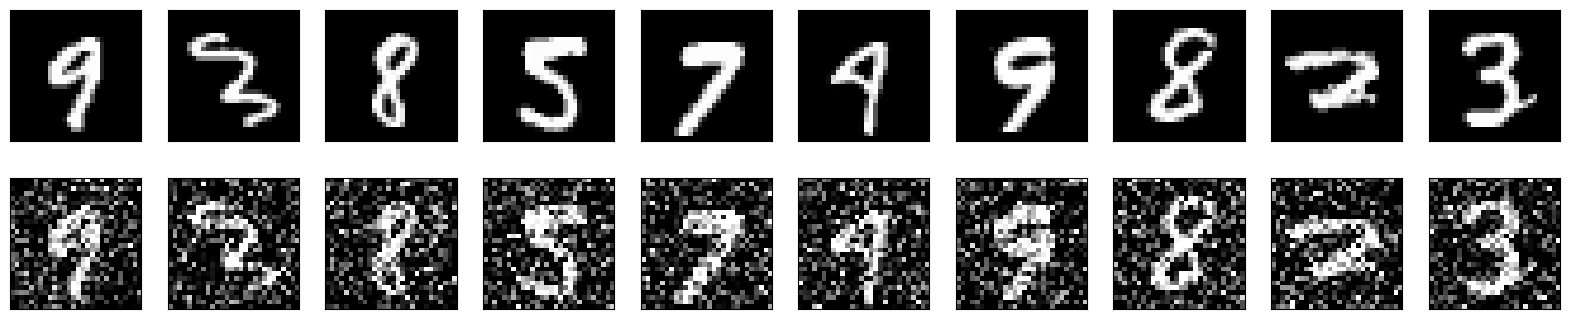

In [8]:
# display batch of images
# Fetch the first batch
batch_images, _ = next(iter(train_loader))
print(type(batch_images), batch_images.shape)

# Generate list of noisy images
batch_noisy_images = noise(batch_images)

# Convert the images from PyTorch tensors to numpy arrays
# Note: This step is necessary because the display function expects numpy arrays
batch_images_np = batch_images.numpy()
batch_noisy_images_np = batch_noisy_images.numpy()
print(type(batch_images_np), batch_images_np.shape)
print(type(batch_noisy_images_np), batch_noisy_images_np.shape)

# Now you can call your display function
# As an example, displaying the same images for both parameters
display(batch_images_np, batch_noisy_images_np)

In [9]:
# Instantiate the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [11]:
# Train the model
for epoch in range(100):
    for data in train_loader:
        imgs, _ = data
        noisy_imgs = noise(imgs).to(device)
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.10706992447376251
Epoch 2, Loss: 0.09906165301799774
Epoch 3, Loss: 0.0986802950501442
Epoch 4, Loss: 0.09846547991037369
Epoch 5, Loss: 0.09541838616132736
Epoch 6, Loss: 0.09290875494480133
Epoch 7, Loss: 0.0966002568602562
Epoch 8, Loss: 0.08970519155263901
Epoch 9, Loss: 0.09332320839166641
Epoch 10, Loss: 0.09088531881570816
Epoch 11, Loss: 0.09300916641950607
Epoch 12, Loss: 0.09132760018110275
Epoch 13, Loss: 0.09340299665927887
Epoch 14, Loss: 0.09159477055072784
Epoch 15, Loss: 0.08993041515350342
Epoch 16, Loss: 0.09150120615959167
Epoch 17, Loss: 0.09052383899688721
Epoch 18, Loss: 0.09033263474702835
Epoch 19, Loss: 0.09367962181568146
Epoch 20, Loss: 0.09015145897865295
Epoch 21, Loss: 0.08873853832483292
Epoch 22, Loss: 0.09229094535112381
Epoch 23, Loss: 0.09106608480215073
Epoch 24, Loss: 0.08633676171302795
Epoch 25, Loss: 0.09193097800016403
Epoch 26, Loss: 0.09308353066444397
Epoch 27, Loss: 0.08831624686717987
Epoch 28, Loss: 0.09172055870294571
Epo

KeyboardInterrupt: 

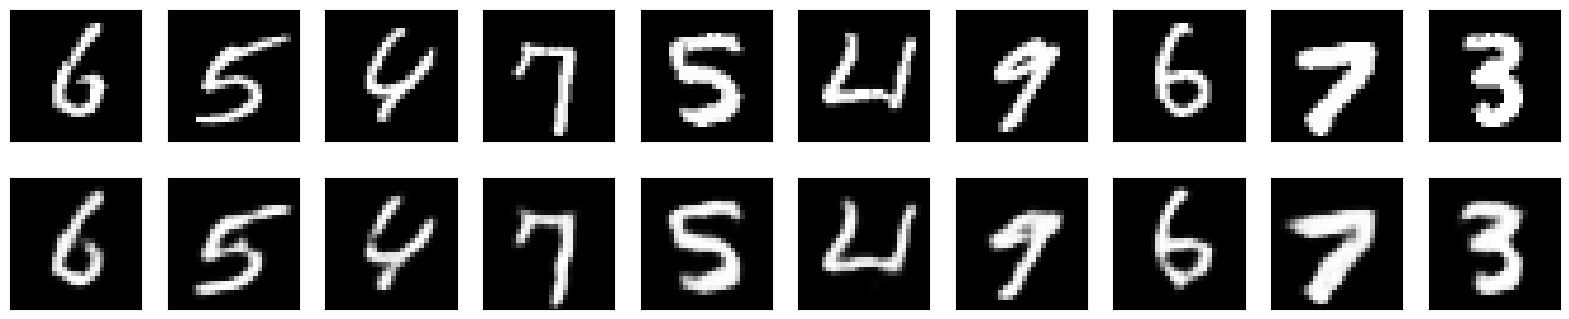

In [12]:
# Test the model
model.eval()
with torch.no_grad():
    for data in test_loader:
        imgs, _ = data
        noisy_imgs = noise(imgs).to(device)
        outputs = model(noisy_imgs)
        break

# Display results
display(imgs.cpu().numpy(), outputs.cpu().numpy())